In [12]:
!pip install xgboost imbalanced-learn seaborn tensorflow


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, Input


In [14]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("EEG.machinelearing_data_BRMH.csv")  # adjust name if different


Saving EEG.machinelearing_data_BRMH.csv to EEG.machinelearing_data_BRMH (2).csv


In [19]:
# Encode object columns
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Target encoding
target_encoder = LabelEncoder()
df['target'] = target_encoder.fit_transform(df['main.disorder'].astype(str))
df = df.drop(columns=['main.disorder', 'specific.disorder'], errors='ignore')

# Fill NaNs, remove constant columns
df = df.fillna(df.mean(numeric_only=True))
df = df.loc[:, df.nunique() > 1]


In [20]:
X = df.drop(columns=['target'])
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance using SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

print("✅ Data balanced:", X_bal.shape)


✅ Data balanced: (1862, 1146)


In [21]:
import antropy as ant
from nolds import lyap_r, corr_dim

# Chaos feature extraction from each sample (assuming each row is a time-series signal)
def extract_chaos_features(row):
    try:
        le = lyap_r(row)
    except:
        le = np.nan
    try:
        cd = corr_dim(row, emb_dim=10)
    except:
        cd = np.nan
    try:
        ae = ant.app_entropy(row)
    except:
        ae = np.nan
    return pd.Series([le, cd, ae])

# Apply chaos features to each row
chaos_features = pd.DataFrame(X.apply(extract_chaos_features, axis=1).values,
                              columns=['lyapunov_exp', 'corr_dim', 'approx_entropy'])

# Add chaos features to X
X = pd.concat([X.reset_index(drop=True), chaos_features], axis=1)

# Fill NaNs if any from chaos features
X = X.fillna(X.mean(numeric_only=True))



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [22]:
# Reshape: (samples, timesteps, features=1)
X_seq = X_bal.reshape((X_bal.shape[0], X_bal.shape[1], 1))

model = Sequential([
    Input(shape=(X_seq.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_bal)), activation='softmax')  # temporary for training
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN+LSTM
history = model.fit(X_seq, y_bal, epochs=50, batch_size=8, validation_split=0.2)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.1663 - loss: 1.9240 - val_accuracy: 0.0107 - val_loss: 2.1933
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.2370 - loss: 1.8552 - val_accuracy: 0.0885 - val_loss: 2.3850
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.3488 - loss: 1.6624 - val_accuracy: 0.0375 - val_loss: 2.1853
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4526 - loss: 1.4626 - val_accuracy: 0.1609 - val_loss: 2.0075
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.4714 - loss: 1.3129 - val_accuracy: 0.1314 - val_loss: 2.0514
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4955 - loss: 1.3094 - val_accuracy: 0.3029 - val_loss: 1.7798
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5471 - loss: 1.1928 - val_accuracy: 0.2413 - val_loss: 1.9767
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5538 - loss: 1.1658 - val_

In [23]:
# Remove softmax layer to use dense(128) output as features
feature_model = Sequential(model.layers[:-1])  # till last dense(128)

deep_features = feature_model.predict(X_seq)
print("✅ Deep features shape:", deep_features.shape)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
✅ Deep features shape: (1862, 128)


In [24]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    deep_features, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_bal))
)

xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:05:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

📈 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        53
           1       0.90      0.98      0.94        53
           2       0.93      0.96      0.94        53
           3       0.96      0.93      0.94        54
           4       0.96      0.96      0.96        53
           5       0.94      0.91      0.92        53
           6       0.96      0.83      0.89        54

    accuracy                           0.94       373
   macro avg       0.94      0.94      0.94       373
weighted avg       0.94      0.94      0.94       373



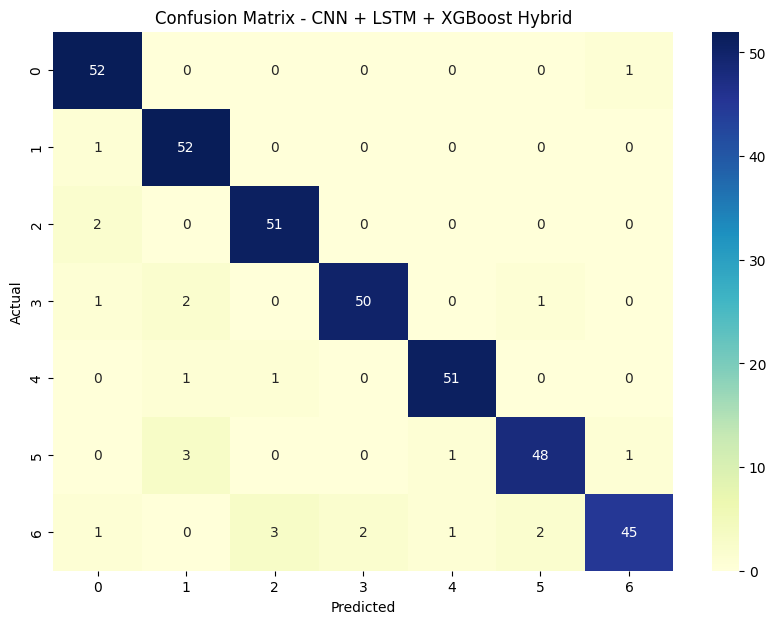

In [25]:
y_pred = xgb.predict(X_test)

print("📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cmap='YlGnBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN + LSTM + XGBoost Hybrid")
plt.show()
